## Reflectance of a Waveguide Taper

This example involves computing the reflectance of the fundamental mode of a linear waveguide taper. The structure and the simulation parameters are shown in the schematic below. We will verify that computing the reflectance, the fraction of the incident power which is reflected, using two different methods produces nearly identical results: (1) mode decomposition and (2) [Poynting flux](https://meep.readthedocs.io/en/latest/Introduction/#transmittancereflectance-spectra). Also, we will demonstrate that the scaling of the reflectance with the taper length is quadratic, consistent with analytical results from [Optics Express, Vol. 16, pp. 11376-92, 2008](http://www.opticsinfobase.org/abstract.cfm?URI=oe-16-15-11376).

![](https://meep.readthedocs.io/en/latest/images/waveguide-taper.png)

The structure, which can be viewed as a [two-port network](https://en.wikipedia.org/wiki/Two-port_network), consists of a single-mode waveguide of width 1 μm (`w1`) at a wavelength of 6.67 μm and coupled to a second waveguide of width 2 μm (`w2`) via a linearly-sloped taper of variable length `Lt`. The material is silicon with ε=12. The taper geometry is defined using a single [`Prism`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#prism) object with eight vertices. PML absorbing boundaries surround the entire cell. An eigenmode current source with E<sub>z</sub> polarization is used to launch the fundamental mode. The dispersion relation (or "band diagram") of the single-mode waveguide is shown in [Tutorial/Eigenmode Source/Index-Guided Modes in a Ridge Waveguide](https://meep.readthedocs.io/en/latest/Python_Tutorials/Eigenmode_Source#index-guided-modes-in-a-ridge-waveguide). There is an eigenmode-expansion monitor placed at the midpoint of the first waveguide. This is a line monitor which extends beyond the waveguide in order to span the entire mode profile including its evanescent tails. The Fourier-transformed fields along this line monitor are used to compute the basis coefficients of the harmonic modes. These are computed separately via the eigenmode solver [MPB](https://mpb.readthedocs.io/en/latest/). This is described in [Mode Decomposition](https://meep.readthedocs.io/en/latest/Mode_Decomposition) where it is also shown that the squared magnitude of the mode coefficient is equivalent to the power (Poynting flux) in the given eigenmode. The ratio of the complex mode coefficients can be used to compute the [S parameters](https://en.wikipedia.org/wiki/Scattering_parameters). In this example, we are computing |S<sub>11</sub>|<sup>2</sup> which is the reflectance (shown in the line prefixed by "refl:,"). Another line monitor could have been placed in the second waveguide to compute the transmittance or |S<sub>21</sub>|<sup>2</sup> into the various guided modes (since the second waveguide is multi mode). The scattered power into the radiative modes can then be computed as 1-|S<sub>11</sub>|<sup>2</sup>-|S<sub>21</sub>|<sup>2</sup>. Following usual practice, a normalization run is required involving a straight waveguide to compute the power in the source.

The structure has mirror symmetry in the $y$ direction which can be exploited to reduce the computation size by a factor of two. This requires using `add_flux` rather than `add_mode_monitor` (which is not optimized for symmetry) and specifying the keyword argument `eig_parity=mp.ODD_Z+mp.EVEN_Y` in the call to `get_eigenmode_coefficients`. Alternatively, the waveguide could have been oriented along an arbitrary oblique direction which would require specifying `direction=mp.NO_DIRECTION` and `kpoint_func` as the waveguide axis. For an example, see [Tutorials/Eigenmode Source/Index-Guided Modes in a Ridge Waveguide](https://meep.readthedocs.io/en/latest/Python_Tutorials/Eigenmode_Source/#index-guided-modes-in-a-ridge-waveguide).

In [1]:
import meep as mp
import matplotlib.pyplot as plt

resolution = 25  # pixels/μm

w1 = 1.0  # width of waveguide 1
w2 = 2.0  # width of waveguide 2
Lw = 10.0  # length of waveguides 1 and 2

# lengths of waveguide taper
Lts = [2**m for m in range(4)]

dair = 3.0  # length of air region
dpml_x = 6.0  # length of PML in x direction
dpml_y = 2.0  # length of PML in y direction

sy = dpml_y + dair + w2 + dair + dpml_y

Si = mp.Medium(epsilon=12.0)

boundary_layers = [mp.PML(dpml_x, direction=mp.X), mp.PML(dpml_y, direction=mp.Y)]

lcen = 6.67  # mode wavelength
fcen = 1 / lcen  # mode frequency

symmetries = [mp.Mirror(mp.Y)]

R_coeffs = []
R_flux = []

for Lt in Lts:
    sx = dpml_x + Lw + Lt + Lw + dpml_x
    cell_size = mp.Vector3(sx, sy, 0)

    src_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.2 * Lw)
    sources = [
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=0.2 * fcen),
            center=src_pt,
            size=mp.Vector3(y=sy - 2 * dpml_y),
            eig_match_freq=True,
            eig_parity=mp.ODD_Z + mp.EVEN_Y,
        )
    ]

    # straight waveguide
    vertices = [
        mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
        mp.Vector3(0.5 * sx + 1, 0.5 * w1),
        mp.Vector3(0.5 * sx + 1, -0.5 * w1),
        mp.Vector3(-0.5 * sx - 1, -0.5 * w1),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=[mp.Prism(vertices, height=mp.inf, material=Si)],
        sources=sources,
        symmetries=symmetries,
    )

    mon_pt = mp.Vector3(-0.5 * sx + dpml_x + 0.7 * Lw)
    flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy - 2 * dpml_y))
    )

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    res = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    incident_coeffs = res.alpha
    incident_flux = mp.get_fluxes(flux)
    incident_flux_data = sim.get_flux_data(flux)

    sim.reset_meep()

    # linear taper
    vertices = [
        mp.Vector3(-0.5 * sx - 1, 0.5 * w1),
        mp.Vector3(-0.5 * Lt, 0.5 * w1),
        mp.Vector3(0.5 * Lt, 0.5 * w2),
        mp.Vector3(0.5 * sx + 1, 0.5 * w2),
        mp.Vector3(0.5 * sx + 1, -0.5 * w2),
        mp.Vector3(0.5 * Lt, -0.5 * w2),
        mp.Vector3(-0.5 * Lt, -0.5 * w1),
        mp.Vector3(-0.5 * sx - 1, -0.5 * w1),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=[mp.Prism(vertices, height=mp.inf, material=Si)],
        sources=sources,
        symmetries=symmetries,
    )

    flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy - 2 * dpml_y))
    )
    sim.load_minus_flux_data(flux, incident_flux_data)

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

    res2 = sim.get_eigenmode_coefficients(flux, [1], eig_parity=mp.ODD_Z + mp.EVEN_Y)
    taper_coeffs = res2.alpha
    taper_flux = mp.get_fluxes(flux)

    R_coeffs.append(
        abs(taper_coeffs[0, 0, 1]) ** 2 / abs(incident_coeffs[0, 0, 0]) ** 2
    )
    R_flux.append(-taper_flux[0] / incident_flux[0])
    print("refl:, {}, {:.8f}, {:.8f}".format(Lt, R_coeffs[-1], R_flux[-1]))

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00183296 s
Working in 2D dimensions.
Computational cell is 33 x 12 x 0 with resolution 25
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (-17.5,0.5,0)
          (17.5,0.5,0)
          (17.5,-0.5,0)
          (-17.5,-0.5,0)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.447863 s
-----------
MPB solved for omega_1(0.519356,0,0) = 0.176186 after 10 iters
MPB solved for omega_1(0.424206,0,0) = 0.149878 after 7 iters
MPB solved for omega_1(0.424377,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.424377,0,0) = 0.149925 after 1 iters
on time step 2379 (time=47.58), 0.00168153 s/step
field decay(t = 50.02): 7.54740931333862e-08 / 7.54740931333862e-08 = 1.0
on time step 4877 (time=97.54), 0.00160183 s/step
field decay(t = 100.04): 0.001735614282175414 / 0.001735614282175414 = 1.0
on time st

field decay(t = 350.14): 8.582297003142968e-06 / 1.5552337783783405 = 5.518332434942239e-06
on time step 19312 (time=386.24), 0.00163389 s/step
field decay(t = 400.16): 5.083050063922431e-11 / 1.5552337783783405 = 3.268351121606029e-11
run 0 finished at t = 400.16 (20008 timesteps)
MPB solved for omega_1(0.519356,0,0) = 0.176186 after 10 iters
MPB solved for omega_1(0.424206,0,0) = 0.149878 after 7 iters
MPB solved for omega_1(0.424377,0,0) = 0.149925 after 5 iters
MPB solved for omega_1(0.424377,0,0) = 0.149925 after 1 iters
Dominant planewave for band 1: (0.424377,-0.000000,0.000000)
refl:, 2, 0.00007150, 0.00008424
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00330091 s
Working in 2D dimensions.
Computational cell is 36 x 12 x 0 with resolution 25
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (-19,0.5,0)
          (19,0.5,0)
          (19,-0.5,0)
          (-19,-0.5

on time step 4042 (time=80.84), 0.00192733 s/step
field decay(t = 100.04): 0.0017392532865220022 / 0.0017392532865220022 = 1.0
on time step 6101 (time=122.02), 0.00194315 s/step
field decay(t = 150.06): 0.4541781140774447 / 0.4541781140774447 = 1.0
on time step 8223 (time=164.46), 0.00188516 s/step
field decay(t = 200.08): 1.5597082712382018 / 1.5597082712382018 = 1.0
on time step 10355 (time=207.1), 0.00187692 s/step
on time step 12479 (time=249.58), 0.00188403 s/step
field decay(t = 250.1): 1.231655150453248 / 1.5597082712382018 = 0.7896702051053925
on time step 14552 (time=291.04), 0.00193036 s/step
field decay(t = 300.12): 0.030221199579030786 / 1.5597082712382018 = 0.019376187288562084
on time step 16622 (time=332.44), 0.00193299 s/step
field decay(t = 350.14): 6.594515383229233e-06 / 1.5597082712382018 = 4.228044118785151e-06
on time step 18688 (time=373.76), 0.00193665 s/step
field decay(t = 400.16): 3.0985772121881132e-09 / 1.5597082712382018 = 1.986638956353199e-09
on time ste

Note that the reflectance is computed for five different geometrically-scaled taper lengths: 1, 2, 4, 8, and 16 μm. A quadratic scaling of the reflectance with the taper length appears as a straight line on a log-log plot. The results are plotted below.

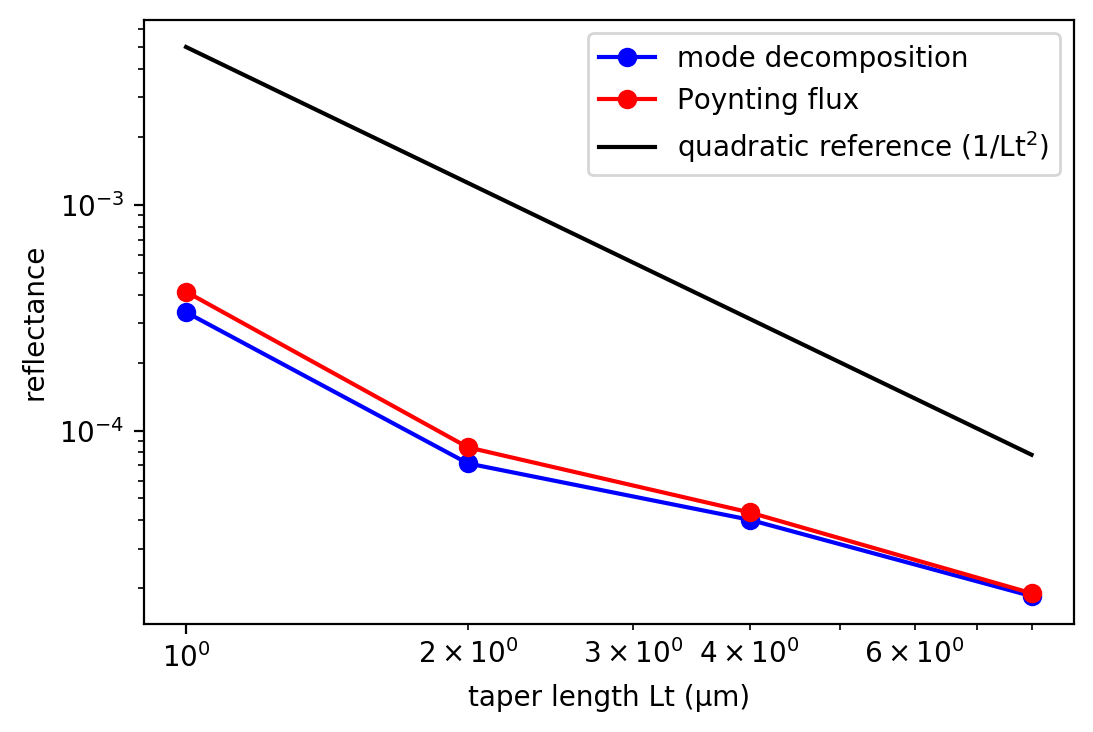

In [2]:
plt.figure(dpi=200)
plt.loglog(Lts, R_coeffs, "bo-", label="mode decomposition")
plt.loglog(Lts, R_flux, "ro-", label="Poynting flux")
plt.loglog(
    Lts, [0.005 / Lt**2 for Lt in Lts], "k-", label=r"quadratic reference (1/Lt$^2$)"
)
plt.legend(loc="upper right")
plt.xlabel("taper length Lt (μm)")
plt.ylabel("reflectance")
plt.show()

The reflectance values computed using the two methods are nearly identical. For reference, a line with quadratic scaling is shown in black. The reflectance of the linear waveguide taper decreases quadratically with the taper length which is consistent with the analytic theory.

In the reflected-flux calculation, we apply our usual trick of first performing a reference simulation with just the incident field and then subtracting that from our taper simulation with `load_minus_flux_data`, so that what is left over is the reflected fields (from which we obtain the reflected flux).  In *principle*, this trick would not be required for the mode-decomposition method, because the reflected mode is orthogonal to the forward mode and so the decomposition will separate the forward and reflected coefficients automatically. However, this is only true in the limit of infinite resolution — for a *finite* resolution, the reflected mode used for the mode coefficient calculation (calculated via MPB) is not exactly orthogonal to the forward mode propagating in Meep (whose discretization scheme is different from that of MPB). In consequence, if you did not subtract the fields of the reference simulation, the mode-coefficient could only calculate the reflected power down to a "noise floor" set by the discretization error. With the subtraction, in contrast, you can compute much smaller reflections (limited by the floating-point precision).